# **Business Understanding**

Uma empresa de e-commerce está buscando entender melhor o comporamento de seus clientes para personalizar
as suas campanhas de marketing. Para isso, a empresa disponibilizou uma base de dados em 'csv' contendo
dados sobre clientes, produtos e transações da loja realizadas entre os anos de **2010** e **2011**.

Com base nesses dados, iremos agrupar os clientes em clusters com base em seu comportamento de compra.
Isso irá permitir identificar padrões e características em comum entre os clientes, como:
- Clientes que compram os mesmos produtos;
- Clientes que possuem a mesma frequência de compra;
- Clientes que gastam mais dinheiro em suas compras.

A partir desses clusters, iremos gerr insights para que a empresa possa segmentar melhor a sua base de 
clientes e personalizar as sua campanhas de marketing, direcionando promoções e ofertas aos clientes com 
base no comportamento de compras.

Os dados fornecidos possuem informações de transações de compras de uma loja de
e-commerce em 38 países e territórios, com mais de 4.000 clientes únicos e mais de
540.000 transações.

# **Data Understanding**

## Bibliotecas

In [1]:
#Pandas e Numpy 
import pandas as pd 
import numpy as np 

#Frequência 
import sidetable

#Visuzalições 
import seaborn as sns 
import matplotlib.pyplot as plt 
import plotly.express as px 

#Clusterização 
from sklearn.cluster import KMeans, AgglomerativeClustering

#Normalização 
from sklearn.preprocessing import StandardScaler, scale

#Métricas 
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

#Graf cotovelo 
from yellowbrick.cluster import kelbow_visualizer

## Padronizando as visualizações

In [2]:
sns.set_theme(
    context= 'talk', #otimizar para apresentação
    style= 'ticks', #marcas nos eixos 
    font_scale=.8, #80% do padrão 
    palette= 'tab10', #10 cores distintas 
    #alterando conf específicas
    rc={
        'figure.figsize' : (10,7), #tamanho 
        'axes.grid' : True, #add linhas 
        'grid.alpha' : .2, #transparencia das linhas
        'axes.titlesize': 'x-large', #tamanhos dos tit dos eixos 
        'axes.titleweight' : 'bold', #negrito nos eixos 
        'axes.titlepad' : 20 #espaçamento de 20 uni entre o titutlo e graf     
    }
   
)

## Dataset

In [3]:
#Importando df 
df = pd.read_csv('data.csv', encoding='latin1')

#Tamanho
df.shape

(541909, 8)

Nosso dataset contém 541.909 linhas e 8 colunas.

In [4]:
#Visualização geral
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Descrição das colunas 

In [5]:
#Infos gerais
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Nosso dataset contém as seguintes colunas, com seus tipos de dados originais:
- InvoiceNo: Identificação da transição, int;
- StockCode: Cód de estoque do produto, str;
- Description: Descrição do produto, str;
- Quantity: Qntd de produtos pro transação, int;
- InvoiceDate: Data da transação, Datetime;
- UnitPrice: Preço unitário do produto, float;
- CustomerID: Identificação do cliente, int,
- Country: País de origem da transação, str. 

**Convertendo a coluna InvoiceDate**

In [6]:
#Convertenedo InvoiceDate para formato DateTime (mês/dia/ano horas/minutos)
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format= '%m/%d/%Y %H:%M')

In [7]:
#Verificando
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [8]:
#Quantidade de valores 
df['InvoiceNo'].sort_values()

0          536365
1          536365
2          536365
3          536365
4          536365
           ...   
540449    C581490
541541    C581499
541715    C581568
541716    C581569
541717    C581569
Name: InvoiceNo, Length: 541909, dtype: object

Qntd total de pedidos = 541.717

## Percentuais por países

In [9]:
#Percentuais de países
df.stb.freq(['Country'])

,Country,count,percent,cumulative_count,cumulative_percent
0,United Kingdom,495478,91.431956,495478,91.431956
1,Germany,9495,1.752139,504973,93.184095
2,France,8557,1.579047,513530,94.763143
3,EIRE,8196,1.512431,521726,96.275574
4,Spain,2533,0.467422,524259,96.742996
5,Netherlands,2371,0.437527,526630,97.180523
6,Belgium,2069,0.381798,528699,97.562321
7,Switzerland,2002,0.369435,530701,97.931756
8,Portugal,1519,0.280305,532220,98.212061
9,Australia,1259,0.232327,533479,98.444388


<Axes: ylabel='Country'>

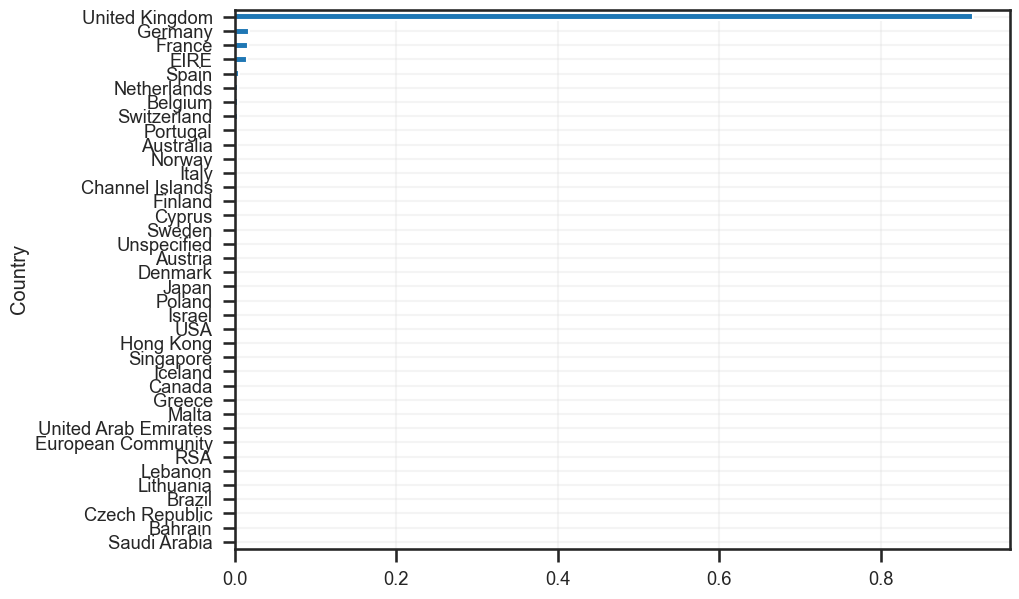

In [10]:
#Vendas por países
df['Country'].value_counts(normalize=True,ascending=True).plot.barh()

## Quantidade de valores e estatísticas

In [11]:
#Quantidade de valores de colunas específicas
df[['Description','Country']].nunique()

Description    4223
Country          38
dtype: int64

In [12]:
#Valores estatísticos de variáveis numéricas
df[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


**Análise**:
Podemos ver que existem valores abaixo de 0, ou seja, negativos.
- Como se trata de valores de vendas, possivelmente os valores negativos se tratam de algum erro, logo devemos tratar esses dados.

## Valores nulos

In [13]:
#Valores nulos no dataframe 
df.isnull().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
StockCode           0
InvoiceNo           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

Podemos ver que temos dados nulos nas seguintes colunas:
- **Description**: 1454 nulos;
- **CustomerID** : 135080 nulos.


## Dados duplicados

In [14]:
#Valores duplicados
df.duplicated().sum()

np.int64(5268)

**Valores duplicados** : 5268

In [15]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Outliers

<Axes: >

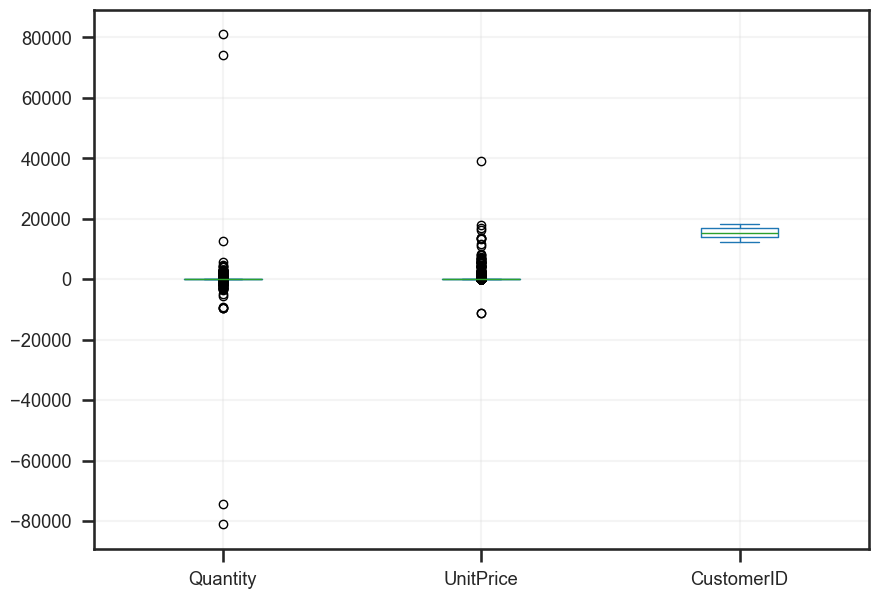

In [16]:
df.plot.box()

- Podemos analisar que temos valores distantes, tanto positivos como negativos, na coluna Quantity.
- Na coluna UnitPrice temos um valor negativo e apenas um acima da média.

# **Data Preparation**

Após fazermos uma análise exploratória dos dados, iremos proseguir para o tratamento dos mesmos, como valores nulos, duplicados e outliers.

## Tratando valores nulos

In [17]:
#Verificando nulos 
df.stb.missing()

,missing,total,percent
CustomerID,135080,541909,24.926694
Description,1454,541909,0.268311
StockCode,0,541909,0.000000
InvoiceNo,0,541909,0.000000
Quantity,0,541909,0.000000
InvoiceDate,0,541909,0.000000
UnitPrice,0,541909,0.000000
Country,0,541909,0.000000


In [18]:
#Excluindo valores nulos na coluna CustomerID
df = df.dropna(subset=['CustomerID'])

In [19]:
#Consultando se foram removidos 
df.stb.missing()

,missing,total,percent
InvoiceNo,0,406829,0.0
StockCode,0,406829,0.0
Description,0,406829,0.0
Quantity,0,406829,0.0
InvoiceDate,0,406829,0.0
UnitPrice,0,406829,0.0
CustomerID,0,406829,0.0
Country,0,406829,0.0


## Tratando valores duplicados

In [20]:
#Verificando valores duplicados 
df[df.duplicated()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom


**Valores duplicados**: 
- Podemos analisar que os valores duplicados na sua maioria, tratam-se de dados duplicados na coluna **InvoiceNo**,
ou seja, do número do pedido. Como o número do pedido pode se repetir no caso do mesmo conter mais de um item/produto no mesmo pedido,
é normal que contenham linhas com valores duplicados, logo não devemos excluí-los.


## Alterando tipos de dados 

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [22]:
df = df.copy()

Trocar CustomerID para 'int' e Country para 'category', visto que são tipos de dados que ocupam menos memória.

In [23]:
#Alterando os tipos de dados 
df['CustomerID'] = df['CustomerID'].astype(int)
df['Country'] = df['Country'].astype('category')


In [24]:
#Verificando 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int64         
 7   Country      406829 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 25.2+ MB


## Tratando Outliers

<Axes: >

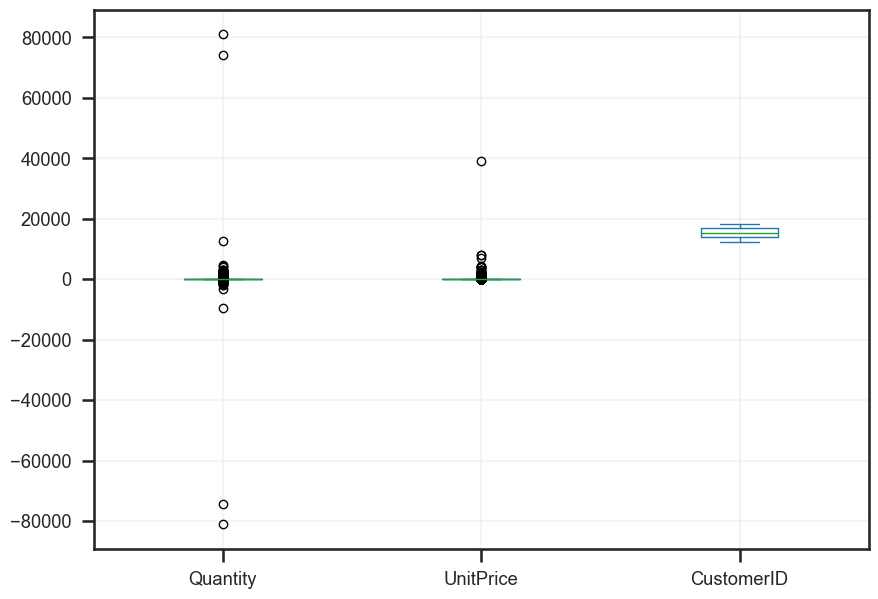

In [25]:
#Valores extremos coluna Quantity
df.plot.box()

In [26]:
#Verificando valores negativos da coluna Quantity 
under0 = df[['Quantity','UnitPrice']].le(0).any(axis=1)

under0.sum()

np.int64(8945)

8945 valores abaixo de 0 na coluna Quantity, vamos tirá-los de nosso dataset pois não faz sentido deixarmos valores negativos.

In [27]:
#Definindo df sem valores negativos 
df = df[~under0].copy()

<Axes: >

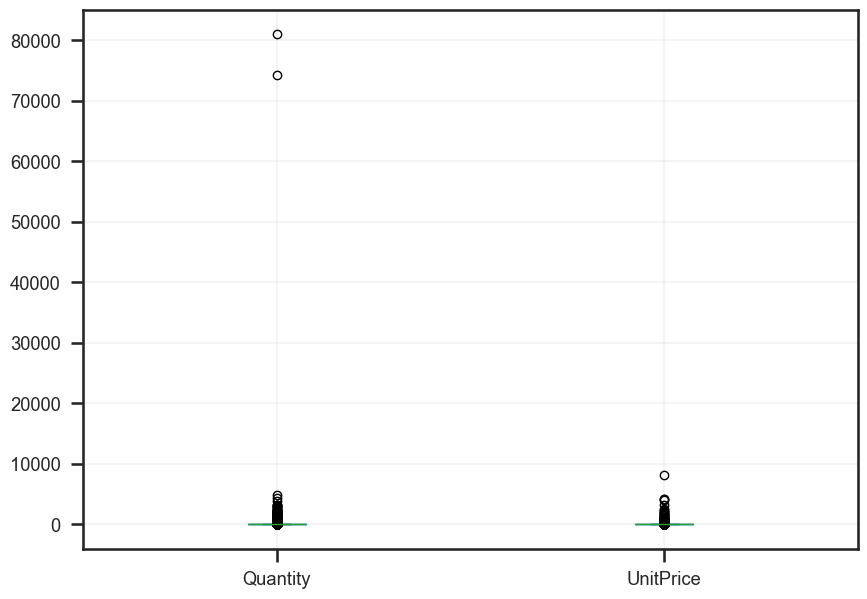

In [28]:
#Verficando se ainda existem valores negativos 
df[['Quantity','UnitPrice']].plot.box()

Podemos ver valores extremos na coluna Quantity, vamos avaliar quais são estes dados.

In [29]:
#Valores acima de 10k na coluna Quantity
df.query('Quantity >10_000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


<Axes: >

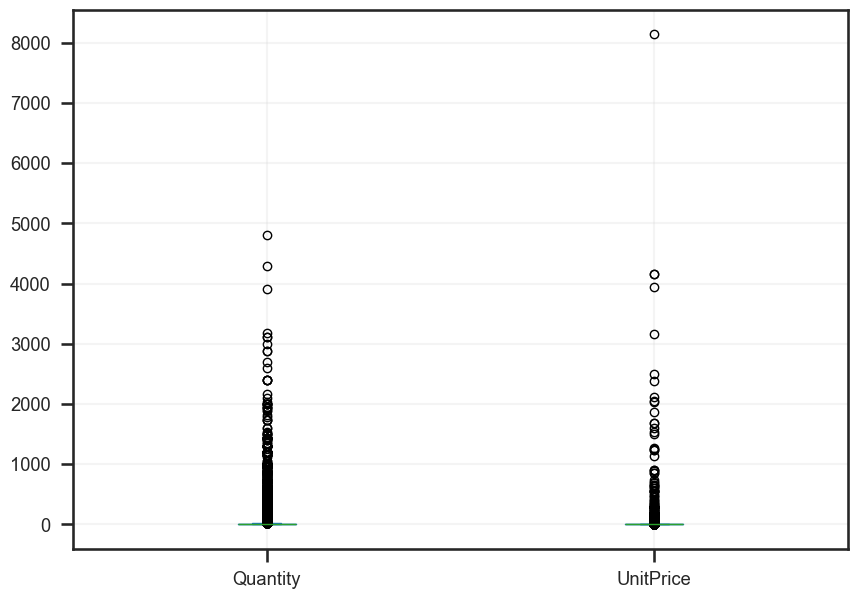

In [30]:
#Valores abaixo de 10k das coluns Quantity e UnitPrice
df.query('Quantity <10_000')[['Quantity','UnitPrice']].plot.box()

In [31]:
#Valores acima de 8k em UnitPrice 
df.query('UnitPrice>8000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom


**Remoção de Outliers**

- Optamos por remover valores acima de 10.000 na coluna 'Quantity', visto que são valores muito acima da média.
- Também vamos remover os valores acima de 8.000 em 'UnitPrice', pois só existe um registro e ele se torna um outlier em relação a média.

In [32]:
#Definindo meu df sem outliers
df = df.query('Quantity<10_000 & UnitPrice<8000').copy()

**Coluna preço total**

In [33]:
#Criando a coluna TotalPrice 
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [34]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


## **RFM**

Após tratramos os dados vamos seguir para a etapa do RMF, entre 2010 e 2011, que consiste em calcular:
- Rencência
- Frequência
- Valor Monetário/Ticket Médio



In [35]:
#Ultima data  
data_max = df['InvoiceDate'].max()
data_max


Timestamp('2011-12-09 12:50:00')

In [36]:
#Menor data
min_data = df['InvoiceDate'].min()
min_data

Timestamp('2010-12-01 08:26:00')

In [37]:
#Calculando o RFM 
df_rfm = (
    df.groupby('CustomerID')  #agrupamos pelo ID do cliente
    .agg(                                                         #função de agregação
        R =('InvoiceDate', lambda x: (data_max - x.max()).days), #n de dias desde a ultima compra 
        F =('InvoiceNo', 'nunique'), #qnt de pedidos unicos 
        M =('TotalPrice', 'mean') #valor medio
        
    ))
      

df_rfm

,R,F,M
CustomerID,,,
12347,1,7,23.681319
12348,74,4,57.975484
12349,18,1,24.076027
12350,309,1,19.670588
12352,35,8,29.482824
...,...,...,...
18280,277,1,18.060000
18281,180,1,11.545714
18282,7,2,14.837500


**Normalização**

<Axes: >

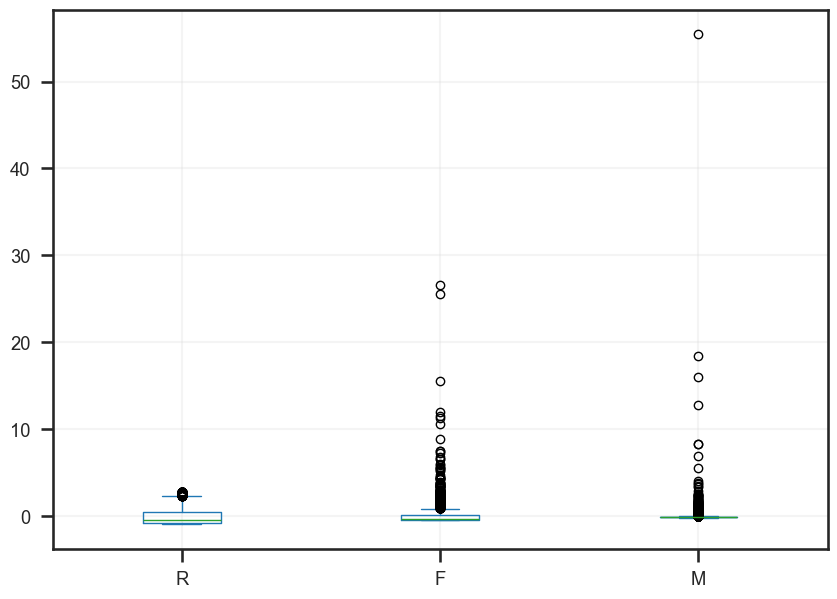

In [38]:
#Aplicando a normalização no RFM 
df_rfm.apply(scale).plot.box()

- Podemos ver que existe um ID com um valor monetário médio muito alto e discrepante em relação aos demais, devemos analisar esse registro.

In [39]:
#Normalizando outlier acima de 50 
df_rfm.apply(scale).query('M>50')

,R,F,M
CustomerID,,,
15098,0.895091,-0.165317,55.434876


In [40]:
#Visualizando ID do outlier 
df.query('CustomerID == 15098')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
222670,556442,22502,PICNIC BASKET WICKER SMALL,60,2011-06-10 15:22:00,4.95,15098,United Kingdom,297.0
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom,38970.0
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098,United Kingdom,649.5


 Podemos ver que se trate de um cliente que comprou muitas quantidade de itens de itens com valores relativamente altos.
 - Optamos por exclui-lo, pois é um cliente unico que difere da média, o que irá interferir no valor médio.

In [41]:
#Excluindo 
df_rfm = df_rfm.drop(15098)

<Axes: >

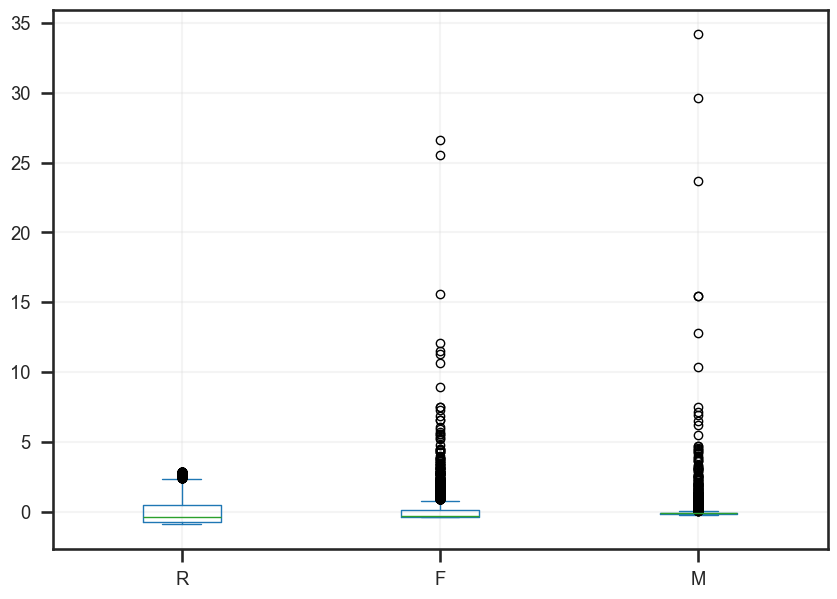

In [42]:
#Analisando outros possíveis outliers
df_rfm.apply(scale).plot.box()

Análise: 
- Podemos ver que ainda existem alguns outliers no nosso RFM, em Frequência e e Valor total gasto pelo cliente. 
- Vamos optar por estabilizar a variança dos dados, utilizando o Power Transform e o método Clip, tornando os dados mais proximos um dos outros.
- O melhor método que se adequar aos dados será utilizado.

**Power Transform**

In [43]:
#Lib
from sklearn.preprocessing import PowerTransformer

#Algoritimo
scaler = PowerTransformer()

In [44]:
#Aplicando Pw 
df_rfm_scale = scaler.fit_transform(df_rfm)

#Tranformando novamente em um df
df_rfm_scale = pd.DataFrame(df_rfm_scale, columns= df_rfm.columns, index= df_rfm.index)
df_rfm_scale

,R,F,M
CustomerID,,,
12347,-1.843196,1.201866,0.407836
12348,0.291366,0.660670,1.329304
12349,-0.679767,-1.158070,0.426829
12350,1.573774,-1.158070,0.189376
12352,-0.256739,1.309671,0.653411
...,...,...,...
18280,1.463610,-1.158070,0.085562
18281,1.049619,-1.158070,-0.491003
18282,-1.181793,-0.195707,-0.161007


<Axes: >

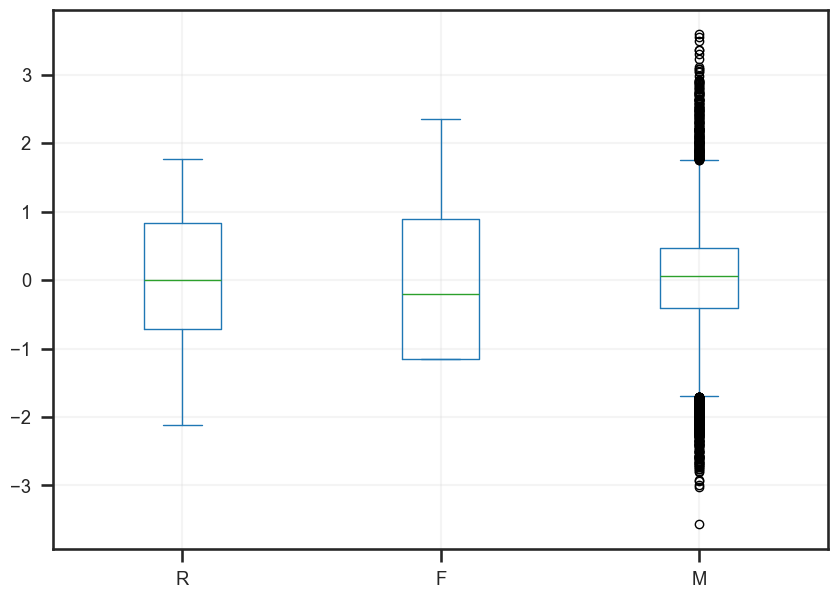

In [45]:
#Visualizando no plot box
df_rfm_scale.plot.box()

- Podemos ver que o Power Transform normalizou os dados, como existia muita variança, ocorreu por gerar valores negativos também.

**Clip**
- Vamos usar o método .clip para limitar valores.

In [46]:
#Análise estatística
df_rfm.describe()

,R,F,M
count,4336.000000,4336.000000,4336.000000
mean,91.509225,4.272601,34.554185
std,99.970323,7.697927,129.202663
min,0.000000,1.000000,1.450000
25%,17.000000,1.000000,12.339095
50%,50.000000,2.000000,17.715999
75%,141.000000,5.000000,24.843993
max,373.000000,209.000000,4453.430000


Análise:
- Em Frequência e em Valor Monetário, os valores máximos estão muito distantes dos 75% dos dados, ou seja, existem muitos outliers como vimos.
- Vamos optar por usar o método .clip para os valores que estejam acima de 95% do total dos dados, não ultrapassarem essa médida.

In [47]:
#Limitando os outliers em 95% dos dados 
df_rfm_clip = df_rfm.apply(lambda x: x.clip(upper= x.quantile(.95)))

In [48]:
#Analisando como ficou
df_rfm_clip.describe()

,R,F,M
count,4336.000000,4336.000000,4336.000000
mean,89.750231,3.608164,23.634656
std,95.564917,3.358999,20.993635
min,0.000000,1.000000,1.450000
25%,17.000000,1.000000,12.339095
50%,50.000000,2.000000,17.715999
75%,141.000000,5.000000,24.843993
max,311.000000,13.000000,91.768421


<Axes: >

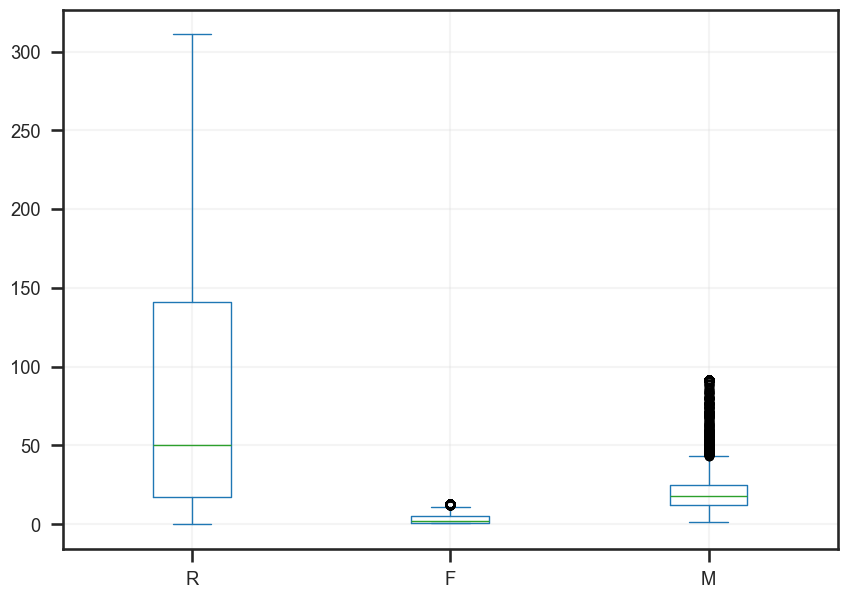

In [49]:
df_rfm_clip.plot.box()

In [50]:
#Normalizando os dados
df_rfm_clip_scaled = df_rfm_clip.apply(scale)

**Conclusão**:
- Após fazer todo o processo de data cleaning, o método .clip se mostrou o mais adequado para tratar valores dicrepantes.

# **Modelling & Model Evaluation** 

# K-Means

In [51]:
#Lib 
from sklearn.cluster import KMeans

**Kelbow visualizer**
- Vamos analisar a possível melhor quantidade de clusters com o método do cotovelo.

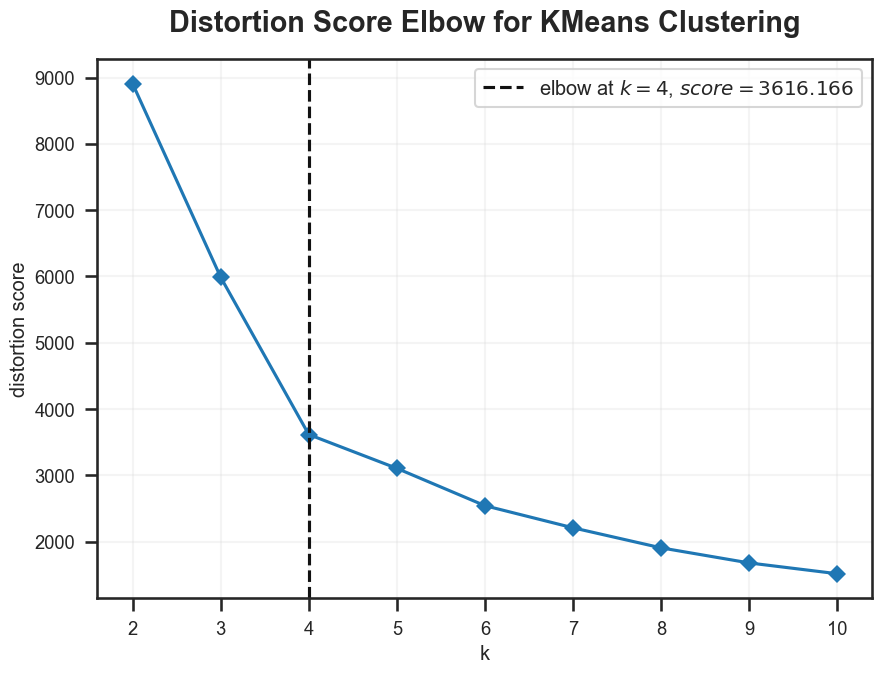

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [52]:
#Lib 
from yellowbrick.cluster import kelbow_visualizer

#Aplicando o gráfico com 10 clusters 
kelbow_visualizer(KMeans(), df_rfm_clip_scaled, k=10, timings= False)

- O método Kelbow visualizer sinalizou como a melhor quantidade de clusters para nosso conjunto de dados como **K = 4**.

**Métricas**
- Vamos avaliar o nosso modelo de KMeans com as métricas de **Silhouette score, Davies Bouldin score e Calinski Harabasz score**.

In [53]:
#Libs 
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

#Criando variável e lista para as métricas
cluster_metrics = (silhouette_score, davies_bouldin_score, calinski_harabasz_score)
cluster_metrics_results = []

#Definindo variável X como meu df 
X = df_rfm_clip_scaled.copy()

#Dicionário para utlizar as métricas de 1 até 10 clusters
for k in range(2,11):
    #Definir e treinar o modelo
    model = KMeans(n_clusters=k, random_state=0 )
    labels = model.fit_predict(X)
    #Resultados e inércia
    cluster_results_dict = {'k': k}
    cluster_results_dict['inertia'] = model.inertia_
    #Colocando as métricas no dicionário
    for metric in cluster_metrics:
        cluster_results_dict[metric.__name__] = metric(X, labels)
    #Add métricas a lista
    cluster_metrics_results.append(cluster_results_dict)
    
#Transformando métricas em um um df e tabela
pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()
        
    

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,9608.282099,0.481591,1.042497,1533.507992
3,6381.823644,0.395701,0.918130,2249.454015
4,3616.166561,0.479596,0.704605,3750.330076
5,3105.555023,0.386128,0.854972,3452.484443
6,2543.164050,0.397696,0.851392,3563.493253
7,2240.793878,0.401835,0.849584,3466.869172
8,1907.307548,0.383725,0.861791,3598.585435
9,1669.043657,0.394068,0.800887,3674.592738
10,1559.763088,0.330879,0.922023,3528.065801


Análise métricas K-Means:
- *Inertia*: quando maior a inércia, mais compactos estão os dados. k = 2
- *Sillhouetter score*: quanto mais perto de 1, mais bem definidos estão os clusters.  k = 4
- *Davies Bouldin score*: quanto menor, menos disperso internamente entre o cluster. k = 4
- *Calinski Harabasz score*: quanto maior, menos disperso internamente e mais definido e separado de outros clusters. k = 4


**Conclusão metricas Kmeans**:
Definimos como melhor numero de cluster com o algoritimo K-Means como **K = 4**.

In [54]:
#Definindo K=4
kmeans = KMeans(4)

#Labels para visualização
labels_kmeans = kmeans.fit_predict(df_rfm_clip_scaled)

In [55]:
#Visualizando clusters
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=labels_kmeans.astype(str), template='plotly_dark')


# Clusterização Hierarquica

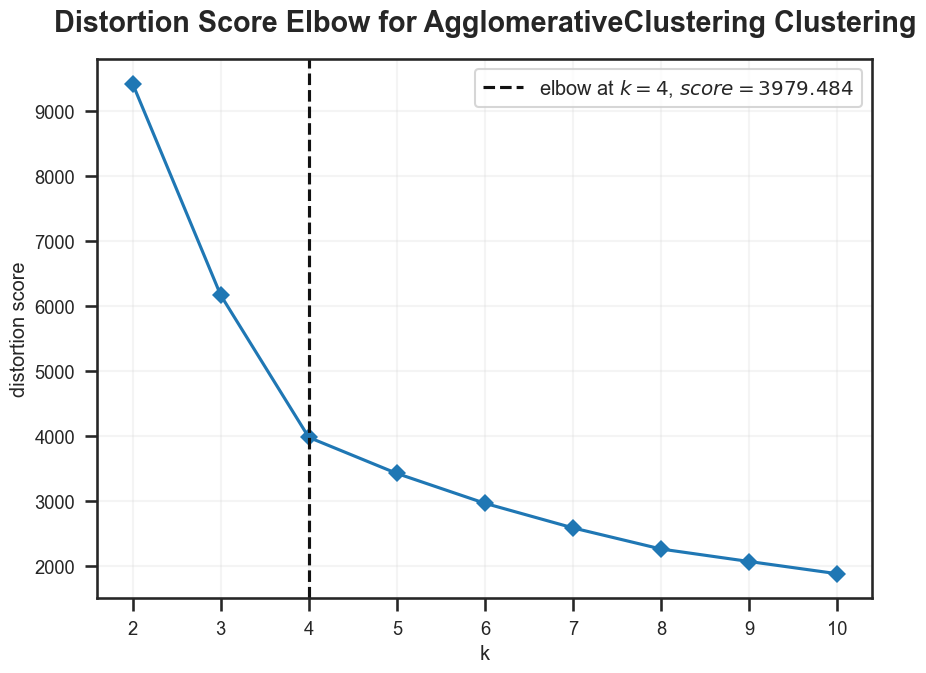

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10),
                 timings=False)

In [56]:
#Kelbow visualizer 
kelbow_visualizer(AgglomerativeClustering(),df_rfm_clip_scaled, k=10, timings=False)

Melhor número de clusters: 4

**Métricas**

In [57]:
#Lib
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

#Lista para add as métricas 
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfm_clip_scaled.copy()

#Dicionário clusters 2 a 10 
for k in range(2,11):
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(X)
    cluster_results_dict = {'k' : k}
    for metric in cluster_metrics:
        cluster_results_dict[metric.__name__] = metric(X, labels)
    cluster_metrics_results.append(cluster_results_dict)
    
pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.366218,1.401714,1649.165249
3,0.410780,0.877315,2402.355257
4,0.426824,0.804797,3276.097867
5,0.433213,0.724893,3030.574661
6,0.413187,0.773614,2933.915283
7,0.348179,0.839594,2907.682809
8,0.352214,0.872310,2939.438121
9,0.277369,1.006623,2860.314633
10,0.293698,1.001754,2844.258180


Análise Clusterização Hierárquica:
- *Sillhouette score*: k=5
- *Davies Bouldin score*: k=5
- *Calinski Harabasz score*: k=4 

In [58]:
#Model
hclust = AgglomerativeClustering(n_clusters=4)

#Labels
hclust_labels = hclust.fit_predict(df_rfm_clip_scaled)

In [59]:
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=hclust_labels.astype(str), template='plotly_dark')

## Conclusão dos modelos: 
- Tanto o K-Means como a Clusterização Hierárquica se saíram relativamente bem ao definir os clusters, com boas métricas. 
- Vamos proseguir com o modelo do **K-Means** para usar na interpretação dos clusters.

# **Interpretação dos clusters**

Vamos fazer a interpretação dos 4 grupos de clusters ideais gerados pelo nosso modelo do K-Means.

In [60]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_rfm_clip_scaled.columns)

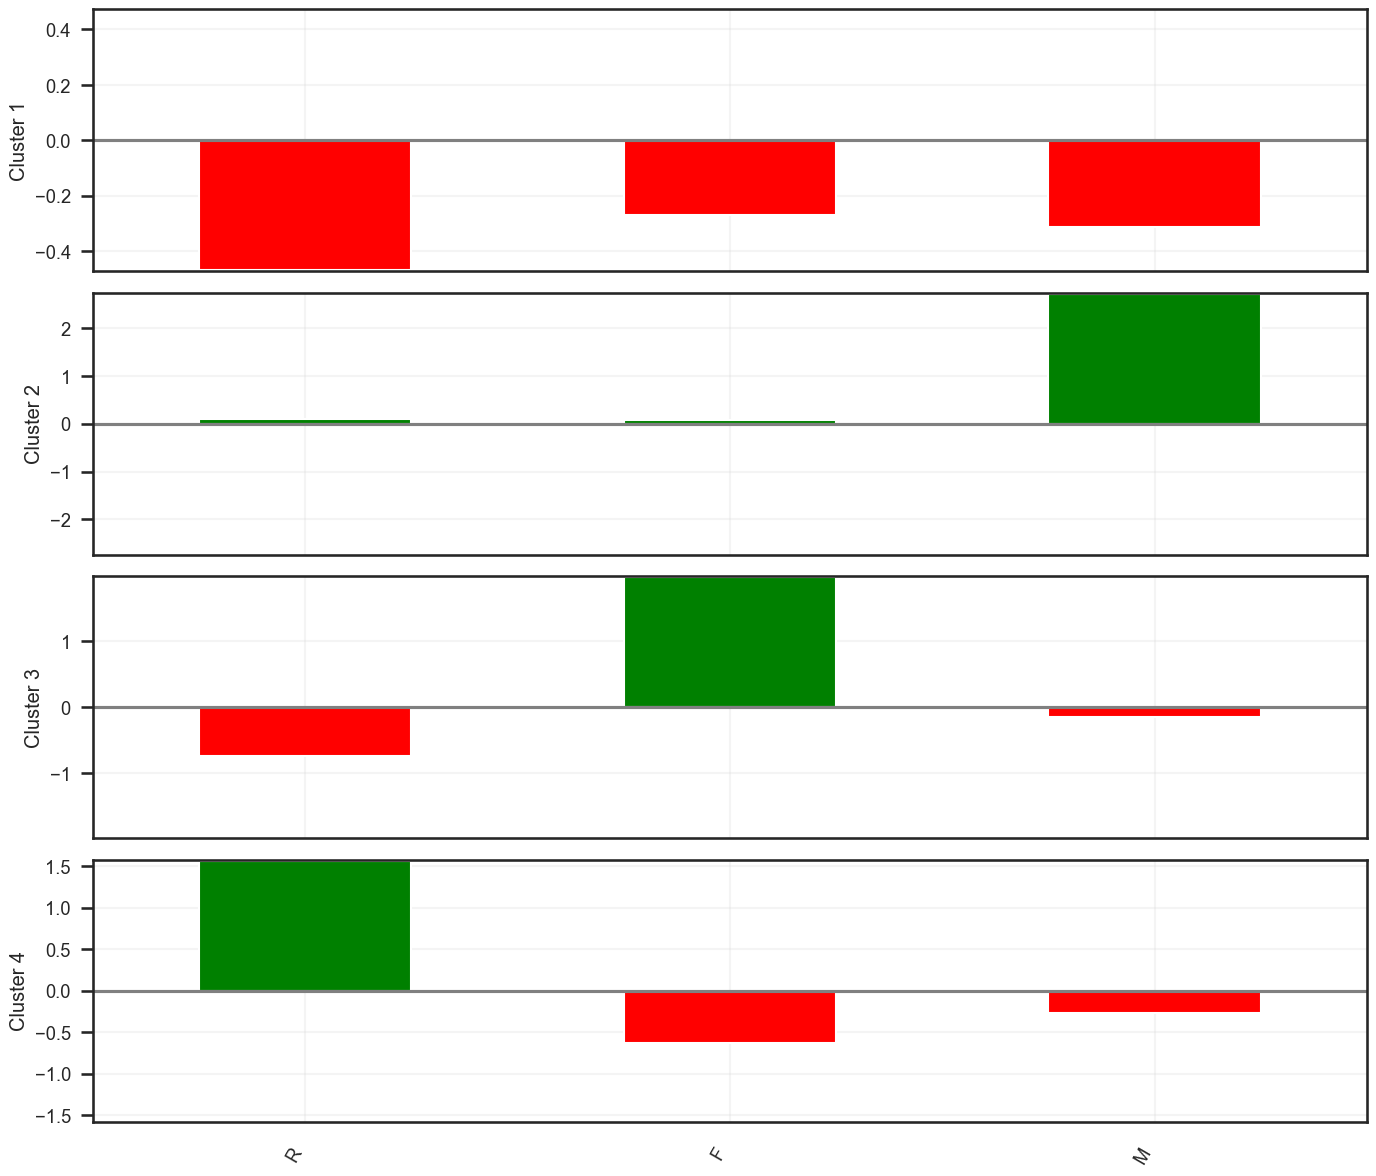

In [61]:
#Definindo a conf do gráfico p 4 clusters (axes)
fig, axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

#Usando for para plotar os clusters 
for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none') 

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()




## **Interpretando**

**Cluster 1**
 - Ticket médio: Muito alto
 - Frequência: Médio
 - Recência: Baixa

Este grupo representa clientes VIP, com pedidos de alto valor, mas média e frequência e não tão recentes.

**Cluster 2**
 - Ticket médio: Mutio baixa
 - Frequência: Muito baixa
 - Recência: Alta

Grupo de novos clientes, com uma compra(s) recente porém com uma frquência baixa por serem novos, e um valor baixo gasto.

**Cluster 3** 
 - Ticket médio: Médio
 - Frequência: Muito alto
 - Recência: Alta

São clientes frequentes, que realizam muitos pedidos com ticket médio razoável e compram muito regularmente.

**Cluster 4**
 - Ticket médio: Baixo 
 - Frequência: Baixa
 - Recência: Muito baixa 

 Este perfil sugere clientes inativos ou churn, que não compram há muito tempo, tiveram poucos pedidos no passado e baixo valor médio.

## **Insights**

Com base nessa análise de agrupamento de clientes, algumas ações e estratégias diferenciadas podem ser recomendadas para cada cluster:

**Clientes VIP (Cluster 1)**:

- Manter programa de fidelidade e atendimento personalizado.
- Ofertas exclusivas e serviços premium.
- Garantir estoque e variedade de produtos de maior valor.

**Novos Clientes (Cluster 2)**:

 - Descontos e frete grátis para primeiras compras.
 - Indicação e compartilhamento nas redes sociais.
 - Foco em experiência de usuário no site e apps.

 
**Clientes Frequentes (Cluster 3)**:

 - Ofertas por volume com descontos progressivos.
 - Marketing por push notification para novas coleções.
 - Facilidades no processo de compra e pagamento.

**Clientes Inativos (Cluster 4)**:

 - Pesquisar motivos para evasão e atrair de volta.
 - Oferta para primeira compra após período prolongado.
 - Call center com pesquisa de satisfação.

